In [12]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [13]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # um
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/mat/Material_merged.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/mat/Material_merged.csv"

In [14]:
eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=4)
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5)

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/mat/Material_merged_fit.pkl


-----------
Initializing structure...
time for choose_chunkdivision = 0.000136852 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.051955 s
-----------
ldos0:, 1.4285714285714288, 0.7144502822053472
ldos0:, 1.4321548017200194, 0.7163367761240798
ldos0:, 1.43573817486861, 0.7182723184399172
ldos0:, 1.4393215480172004, 0.7201046747640735
ldos0:, 1.442904921165791, 0.7217945864538683
ldos0:, 1.4464882943143815, 0.7234556823990859
ldos0:, 1.4500716674629721, 0.7252303681313345
ldos0:, 1.4536550406115627, 0.7271371784203956
ldos0:, 1.457238413760153, 0.7290531525318662
ldos0:, 1.4608217869087436, 0.7308476855917039
ldos0:, 1.4644051600573342, 0.7325222170039039
ldos0:, 1.4679885332059248, 0.7342064168813847
ldos0:, 1.4715719063545154, 0.7360174183425182
ldos0:, 1.4751552795031058, 0.7379348486839823
ldos0:, 1.4787386526516964, 0.7398249259377658
ldos0:, 1.482322025800287, 0.7415853532299017
ldos0:, 1.4859053989488775, 0.743254140004423

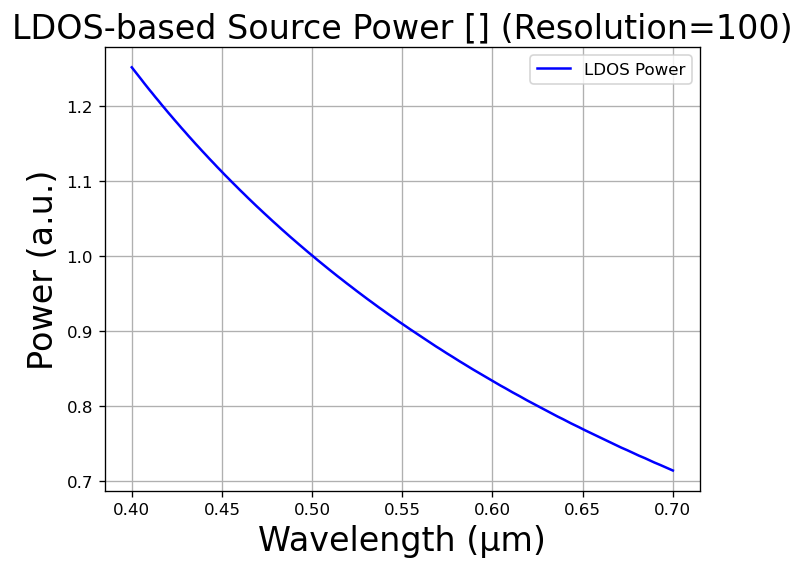

In [57]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import csv

# === 설정 ===
cell_size = mp.Vector3(3, 3, 0)
resolution =100
nfreq = 300
fcen = 1.75
df = 3.3

field_component = mp.Ex

lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# 소스 설정
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

air = mp.Medium(index = 1)

# PML 설정
pml_layers = [mp.PML(0.3)]

# 시뮬레이션 객체 생성
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    # geometry=
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

# === LDOS 객체 생성 ===
freqs = np.linspace(fcen_dft - df_dft/2, fcen_dft + df_dft/2, nfreq)
ldos_obj = mp.Ldos(freqs)

# === 시뮬레이션 실행 ===
sim.run(
    mp.dft_ldos(ldos=ldos_obj),
    until=50
)

# === 결과 얻기 ===
ldos_power = np.array(sim.ldos_data)  # (W) 단위 power
flux_freqs = np.array(mp.get_ldos_freqs(ldos_obj))  # (1/μm) 단위 주파수
wavelengths = 1 / flux_freqs  # (μm) 단위 파장

# === CSV 저장 ===
csv_filename = f"ldos_sourcepower_res{resolution}.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "LDOS Power (a.u.)"])
    for wl, power in zip(wavelengths, ldos_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {csv_filename}")

# === 플롯 저장 ===
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()


In [16]:

plot_filename = f"ldos_sourcepower_res{resolution}.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"플롯 이미지 저장 완료: {plot_filename}")


플롯 이미지 저장 완료: ldos_sourcepower_res100.png


-----------
Initializing structure...
time for choose_chunkdivision = 0.000157118 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.0523219 s
lorentzian susceptibility: frequency=10.5233, gamma=0
lorentzian susceptibility: frequency=9.581, gamma=0.00361007
drude susceptibility: frequency=1, gamma=9.97384
lorentzian susceptibility: frequency=13.0238, gamma=0
lorentzian susceptibility: frequency=2.66313, gamma=0.193333
lorentzian susceptibility: frequency=12.9664, gamma=0
lorentzian susceptibility: frequency=9.35736, gamma=0
drude susceptibility: frequency=1, gamma=3.40764
drude susceptibility: frequency=1, gamma=9.03162
drude susceptibility: frequency=1, gamma=0
lorentzian susceptibility: frequency=5.86464, gamma=1.37868
drude susceptibility: frequency=1, gamma=8.44336
lorentzian susceptibility: frequency=8.25227, gamma=0
lorentzian susceptibility: frequency=3.73793, gamma=1.91772
lorentzian susceptibility: frequency=2.12712, gamma=

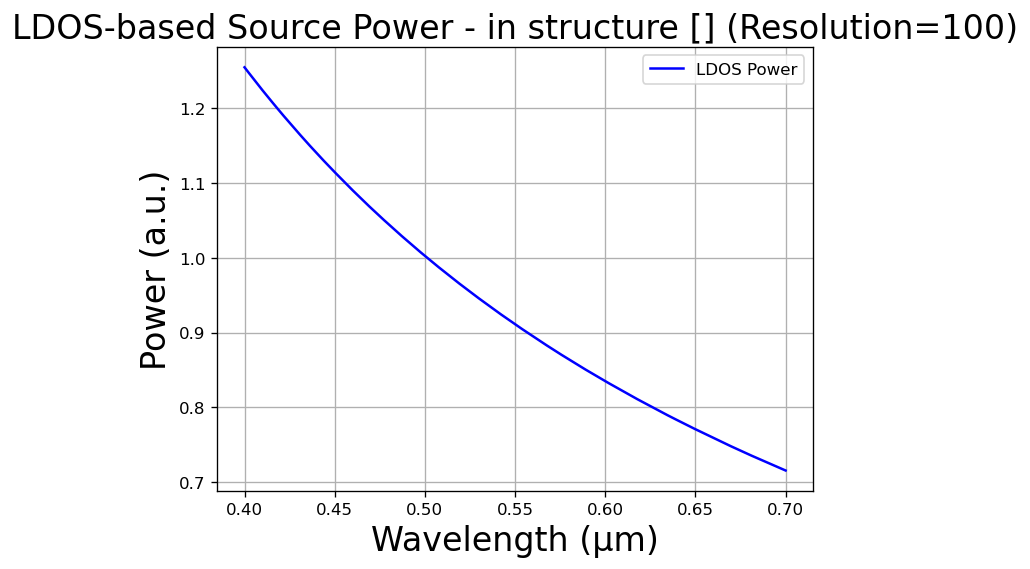

In [59]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import csv

# === 설정 ===
resolution = 100  # ★ 함수 인자였던 것을 변수로 설정
cell_size = mp.Vector3(3, 3, 0)
fcen = 1.75
df = 3.3
nfreq = 300

field_component = mp.Ex

lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# 소스 설정
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

sio2 =  mp.Medium(epsilon = eps_inf_sio2,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = eps_inf_andp,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = eps_inf_al,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)
# cell_size = mp.Vector3(31, 2, 0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,0,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        
        # amplitude = 0.1
)]

# PML 설정
pml_layers = [mp.PML(0.3)]

# === 시뮬레이션 설정 === #
sim_fitting_st = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    # geometry=geometry_fitting,
    default_material=Alq3,
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    # subpixel_maxeval=300,
    # subpixel_tol=1e-8,
    # force_complex_fields = True,
    extra_materials=[Cathode, aNDP, Glass]
)

# === LDOS 객체 생성 ===
freqs = np.linspace(fcen_dft - df_dft/2, fcen_dft + df_dft/2, nfreq)
ldos_obj = mp.Ldos(freqs)

# === 시뮬레이션 실행 ===
sim_fitting_st.run(
    mp.dft_ldos(ldos=ldos_obj),
    until=50
)

# === 결과 얻기 ===
ldos_power_str = np.array(sim_fitting_st.ldos_data)  # (W) 단위 power
flux_freqs = np.array(mp.get_ldos_freqs(ldos_obj))  # (1/μm) 단위 주파수
wavelengths = 1 / flux_freqs  # (μm) 단위 파장

# === CSV 저장 ===
csv_filename = f"ldos_sourcepower_res{resolution} - structure.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "LDOS Power (a.u.)"])
    for wl, power in zip(wavelengths, ldos_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {csv_filename}")

# === 플롯 저장 ===
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power_str, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power - in structure [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()


<Axes: xlabel='X', ylabel='Y'>

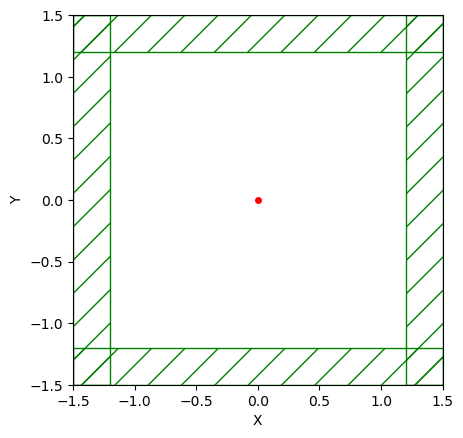

In [60]:
sim_fitting_st.plot2D()

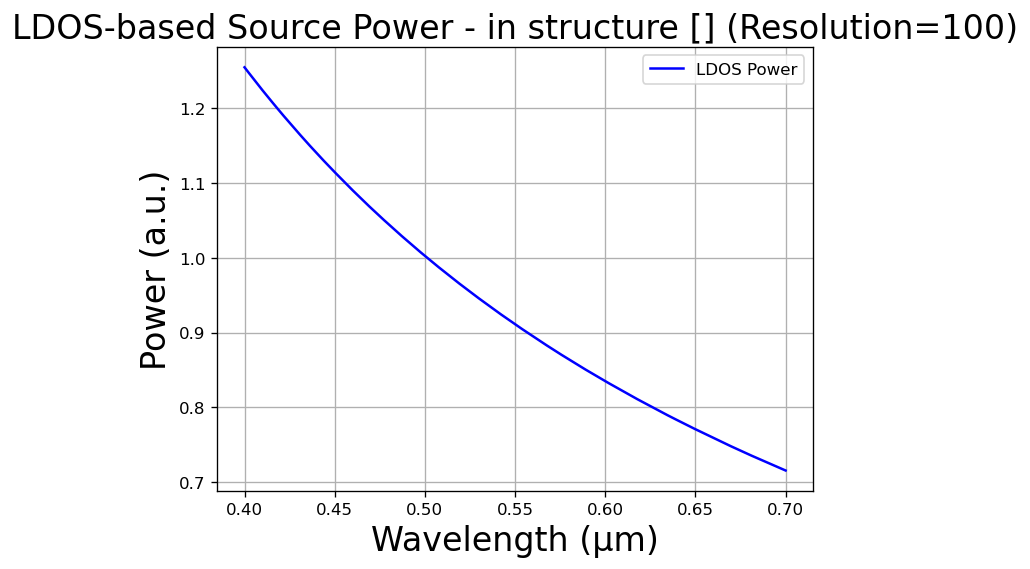

In [61]:
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power_str, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power - in structure [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()

In [40]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path_decaybox = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/decayrate_box.txt")
csv_path_decay = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/decayrate.txt")

# CSV 파일 불러오기
csv_decaybox = np.genfromtxt(csv_path_decaybox, delimiter=",", skip_header=1)
csv_decay = np.genfromtxt(csv_path_decay, delimiter=",", skip_header=1)

decaybox_data = csv_decaybox[:, 1]
decay_data = csv_decay[:, 1]

In [43]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/full/full_400.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

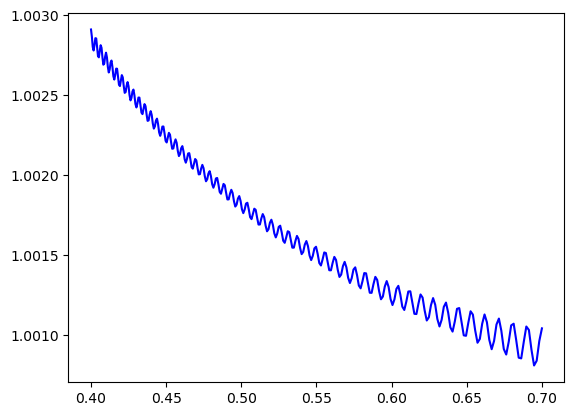

In [62]:
norm = ldos_power_str /ldos_power 
plt.plot(wavelengths, norm, label="LDOS Power", color='blue')
# plt.plot(wavelengths, lumerical, label="Lumerical", color='red')

In [18]:

plot_filename = f"ldos_sourcepower_res{resolution} - in structure.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"플롯 이미지 저장 완료: {plot_filename}")


플롯 이미지 저장 완료: ldos_sourcepower_res100 - in structure.png
